In [1]:
import pickle
import re

In [2]:
from scipy.stats.mstats import zscore

In [3]:
import numpy as np

In [4]:
from tokenize import generate_tokens
from cStringIO import StringIO
from collections import defaultdict
import ast
import astor
from py2_tokenize import tokenize_code

In [5]:
annotations = pickle.load(open('annotations.p', 'rb'))
questions = pickle.load(open('questions.p', 'rb'))

In [6]:
def sub_contiguous_snippets(code_snippet):
    try:
        tokens = [token for _, token, _, _, _  in generate_tokens(StringIO(code_snippet).readline) if token]
    except:
        return []
    sub_snippet_set = set()
    for i in range(len(tokens)):
        for j in range(i+1, len(tokens)+1):
            con_tokens = tokens[i:j]
            if con_tokens[-1] == ':':
                con_tokens.append('pass')
            sub_snippet = ' '.join(con_tokens)
            try:
                root = ast.parse(sub_snippet)
                cc = astor.to_source(root)
                tokenize_code(cc.encode('utf-8'))
                sub_snippet_set.add(cc)
            except:
                pass
    return sub_snippet_set

In [7]:
intents = {post_id: q['intent'] for post_id, q in questions.items()}

In [8]:
candidates = {}
for post_id, q in questions.items():
    cs = set()
    for s in q['snippet']:
        cs |= set(sub_contiguous_snippets(s))
    candidates[post_id] = cs

In [9]:
def concat(context, snippet):
    return astor.to_source(ast.parse(context + '\n' + snippet))

In [11]:
context_pos = defaultdict(set)
snippet_pos = defaultdict(set)
full_pos = defaultdict(set)
for a in annotations:
    post_id = a['post_id']
    if a['context_ref'] in candidates[post_id]:
        context_pos[post_id].add(a['context_ref'])
    if a['snippet_ref'] in candidates[post_id]:
        snippet_pos[post_id].add(a['snippet_ref'])
    if a['snippet_ref'] == '':
        print a
    try:
        full = concat(a['context_ref'], a['snippet_ref'])
        if full in candidates[post_id]:
            full_pos[post_id].add(full)
    except:
        pass

In [171]:
baseline = pickle.load(open('baseline.p', 'rb'))

In [172]:
len(candidates)

111

In [173]:
len(baseline)

21

In [174]:
context_count = 0
snippet_count = 0
full_count = 0
for a in annotations:
    post_id = a['post_id']
    if post_id not in baseline:
        continue
    if a['context_ref'] == baseline[post_id]:
        context_count += 1
    if a['snippet_ref'] == baseline[post_id]:
        snippet_count += 1
    try:
        if concat(a['context_ref'], a['snippet_ref']) == baseline[post_id]:
            full_count += 1
    except:
        pass

In [175]:
context_count, context_count * 1.0 / len(annotations)

(0, 0.0)

In [176]:
snippet_count, snippet_count * 1.0 / len(annotations)

(2, 0.008)

In [177]:
full_count, full_count * 1.0 / len(annotations)

(6, 0.024)

In [12]:
context_count = 0
snippet_count = 0
full_count = 0
for a in annotations:
    post_id = a['post_id']
    if a['context_ref'] in candidates[post_id]:
        context_count += 1
    if a['snippet_ref'] in candidates[post_id]:
        snippet_count += 1
    try:
        if concat(a['context_ref'], a['snippet_ref']) in candidates[post_id]:
            full_count += 1
    except:
        pass

In [13]:
context_count, context_count * 1.0 / len(annotations)

(223, 0.892)

In [14]:
snippet_count, snippet_count * 1.0 / len(annotations)

(213, 0.852)

In [15]:
full_count, full_count * 1.0 / len(annotations)

(134, 0.536)

In [16]:
len(annotations), len(questions)

(250, 111)

In [17]:
pickle.dump(candidates, open('candidates.p', 'wb'))
pickle.dump(intents, open('intents.p', 'wb'))

In [18]:
sum(map(len, candidates.values()))

10971

In [160]:
(223 - 10971) / 223

-49

In [19]:
bi_likelihood = pickle.load(open('bi_likelihood.p', 'rb'))

In [51]:
features = {}
for post_id, q in questions.items():
    intent = intents[post_id]
    features[post_id] = []
    for s in q['snippet']:
        abs_likelihood = {c: bi_likelihood[post_id][c] for c in sub_contiguous_snippets(s)}.items()
        if len(abs_likelihood) <= 1:
            continue
        c, ff = zip(*abs_likelihood)
        ff = np.hstack([np.array(ff), zscore(np.array(ff), axis=0)])
        features[post_id].extend(zip(c, ff))

In [64]:
def generate_x_y(pos_set):
    x = []
    y = []
    for post_id in features:
        for c, ff in features[post_id]:
            x.append(ff)
            y.append(c in pos_set[post_id])
    return np.array(x), np.array(y)

In [65]:
snippet_x, snippet_y = generate_x_y(snippet_pos)

In [66]:
context_x, context_y = generate_x_y(context_pos)

In [67]:
full_x, full_y = generate_x_y(full_pos)

In [68]:
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score

In [77]:
snippet_clf = svm.SVC(probability=True)
cross_val_score(snippet_clf, snippet_x, snippet_y, scoring='roc_auc')

array([ 0.78727873,  0.78583783,  0.78794099])

In [78]:
context_clf = svm.SVC(probability=True)
cross_val_score(context_clf, context_x, context_y, scoring='roc_auc')

array([ 0.74730961,  0.73850345,  0.73845224])

In [79]:
full_clf = svm.SVC(probability=True)
cross_val_score(full_clf, full_x, full_y, scoring='roc_auc')

array([ 0.75401885,  0.77250659,  0.82011456])

In [255]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [143]:
def pr(X, y, num_missed_x):
    plt.figure(figsize=(10, 10))
    random_state = np.random.RandomState(0)
    cv = StratifiedKFold(n_splits=5)
    
    classifier = svm.SVC(probability=True, random_state=random_state, C=0.8)
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    lw = 2
    
    i = 0
    for train, test in cv.split(X, y):
        clf = classifier.fit(X[train], y[train])
        probas_ = clf.predict_proba(X[test])
        # Compute ROC curve and area the curve
        n = len(X[test])
        #print n
        print sum(clf.predict(X[test]))
        print sum(y[test])
        print 'accuracy:', accuracy_score(clf.predict(X[test]), y[test])
        print 'f1_score:', f1_score(clf.predict(X[test]), y[test])
        print 'recall_score:', recall_score(clf.predict(X[test]), y[test])
        
        fpr, tpr, thresholds = precision_recall_curve(y[test], probas_[:, 1])
        #fpr = (fpr * n) / (n + num_missed_x)
        #tpr = (tpr * n) / (n + num_missed_x)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    
        i += 1
    #plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
    
    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

In [258]:
def pr(X, y, num_missed_x):
    plt.figure(figsize=(10, 10))
    random_state = np.random.RandomState(0)
    cv = StratifiedKFold(n_splits=5)
    
    classifier = svm.SVC(probability=True, random_state=random_state, class_weight={1: 50})
    
    mean_f1 = np.linspace(0, 1, 1000)
    mean = .0
    
    lw = 2
    
    i = 0
    for train, test in cv.split(X, y):
        clf = classifier.fit(X[train], y[train])
        
        probas_ = clf.predict_proba(X[test])
        #print y[test]
        #print probas_ > 0.077077077077077075
        for x in np.linspace(0, 1, 100):
            label = probas_[:,0] < x
            print x, 'recall:', recall_score(y[test], label), 'f1:', f1_score(y[test], label), 'precision:', precision_score(y[test], label)
        
        precision, recall, thresholds = precision_recall_curve(y[test], probas_[:, 1])
        f1 = precision * recall / (precision + recall) * 2
        area = auc(recall, precision)
        #fpr = (fpr * n) / (n + num_missed_x)
        #tpr = (tpr * n) / (n + num_missed_x)
        mean += interp(mean_f1, thresholds, f1[:-1])
        #mean_tpr[0] = 0.0
        #roc_auc = auc(fpr, tpr)
        
        plt.plot(thresholds, f1[:-1], lw=lw,
                 label='ROC fold %d, auc (%.4f)' % (i, area))
        #plt.plot(recall, precision, lw=lw,
        #         label='ROC fold %d, auc (%.4f)' % (i, area))
    
        i += 1
    #plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
    mean /= cv.get_n_splits(X, y)
    #mean_tpr /= cv.get_n_splits(X, y)
    #mean_tpr[-1] = 1.0
    #mean_auc = auc(mean_fpr, mean_tpr)
    #plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
    #         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR')
    plt.legend(loc="upper right")
    plt.show()
    return mean

0.0 recall: 0.0 f1: 0.0 precision: 0.0
0.010101010101 recall: 0.0 f1: 0.0 precision: 0.0
0.020202020202 recall: 0.0 f1: 0.0 precision: 0.0
0.030303030303 recall: 0.0 f1: 0.0 precision: 0.0
0.040404040404 recall: 0.0 f1: 0.0 precision: 0.0
0.0505050505051 recall: 0.0 f1: 0.0 precision: 0.0
0.0606060606061 recall: 0.0 f1: 0.0 precision: 0.0
0.0707070707071 recall: 0.0 f1: 0.0 precision: 0.0
0.0808080808081 recall: 0.0 f1: 0.0 precision: 0.0
0.0909090909091 recall: 0.0 f1: 0.0 precision: 0.0
0.10101010101 recall: 0.0 f1: 0.0 precision: 0.0
0.111111111111 recall: 0.0 f1: 0.0 precision: 0.0
0.121212121212 recall: 0.0 f1: 0.0 precision: 0.0
0.131313131313 recall: 0.0 f1: 0.0 precision: 0.0
0.141414141414 recall: 0.0 f1: 0.0 precision: 0.0
0.151515151515 recall: 0.0 f1: 0.0 precision: 0.0
0.161616161616 recall: 0.0 f1: 0.0 precision: 0.0
0.171717171717 recall: 0.0 f1: 0.0 precision: 0.0
0.181818181818 recall: 0.0 f1: 0.0 precision: 0.0
0.191919191919 recall: 0.0 f1: 0.0 precision: 0.0
0.20202

/Users/bowen/.virtualenvs/dynet/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide


0.0 recall: 0.0 f1: 0.0 precision: 0.0
0.010101010101 recall: 0.0 f1: 0.0 precision: 0.0
0.020202020202 recall: 0.0 f1: 0.0 precision: 0.0
0.030303030303 recall: 0.0 f1: 0.0 precision: 0.0
0.040404040404 recall: 0.0 f1: 0.0 precision: 0.0
0.0505050505051 recall: 0.0 f1: 0.0 precision: 0.0
0.0606060606061 recall: 0.0 f1: 0.0 precision: 0.0
0.0707070707071 recall: 0.0 f1: 0.0 precision: 0.0
0.0808080808081 recall: 0.0 f1: 0.0 precision: 0.0
0.0909090909091 recall: 0.0 f1: 0.0 precision: 0.0
0.10101010101 recall: 0.0 f1: 0.0 precision: 0.0
0.111111111111 recall: 0.0 f1: 0.0 precision: 0.0
0.121212121212 recall: 0.0 f1: 0.0 precision: 0.0
0.131313131313 recall: 0.0 f1: 0.0 precision: 0.0
0.141414141414 recall: 0.0 f1: 0.0 precision: 0.0
0.151515151515 recall: 0.0 f1: 0.0 precision: 0.0
0.161616161616 recall: 0.0 f1: 0.0 precision: 0.0
0.171717171717 recall: 0.0 f1: 0.0 precision: 0.0
0.181818181818 recall: 0.0 f1: 0.0 precision: 0.0
0.191919191919 recall: 0.0 f1: 0.0 precision: 0.0
0.20202

0.727272727273 recall: 0.0 f1: 0.0 precision: 0.0
0.737373737374 recall: 0.0 f1: 0.0 precision: 0.0
0.747474747475 recall: 0.0 f1: 0.0 precision: 0.0
0.757575757576 recall: 0.0 f1: 0.0 precision: 0.0
0.767676767677 recall: 0.0 f1: 0.0 precision: 0.0
0.777777777778 recall: 0.0 f1: 0.0 precision: 0.0
0.787878787879 recall: 0.0 f1: 0.0 precision: 0.0
0.79797979798 recall: 0.0 f1: 0.0 precision: 0.0
0.808080808081 recall: 0.0 f1: 0.0 precision: 0.0
0.818181818182 recall: 0.0 f1: 0.0 precision: 0.0
0.828282828283 recall: 0.0 f1: 0.0 precision: 0.0
0.838383838384 recall: 0.0 f1: 0.0 precision: 0.0
0.848484848485 recall: 0.0 f1: 0.0 precision: 0.0
0.858585858586 recall: 0.0 f1: 0.0 precision: 0.0
0.868686868687 recall: 0.0 f1: 0.0 precision: 0.0
0.878787878788 recall: 0.0 f1: 0.0 precision: 0.0
0.888888888889 recall: 0.0425531914894 f1: 0.0519480519481 precision: 0.0666666666667
0.89898989899 recall: 0.0851063829787 f1: 0.0747663551402 precision: 0.0666666666667
0.909090909091 recall: 0.17021

0.131313131313 recall: 0.0 f1: 0.0 precision: 0.0
0.141414141414 recall: 0.0 f1: 0.0 precision: 0.0
0.151515151515 recall: 0.0 f1: 0.0 precision: 0.0
0.161616161616 recall: 0.0 f1: 0.0 precision: 0.0
0.171717171717 recall: 0.0 f1: 0.0 precision: 0.0
0.181818181818 recall: 0.0 f1: 0.0 precision: 0.0
0.191919191919 recall: 0.0 f1: 0.0 precision: 0.0
0.20202020202 recall: 0.0 f1: 0.0 precision: 0.0
0.212121212121 recall: 0.0 f1: 0.0 precision: 0.0
0.222222222222 recall: 0.0 f1: 0.0 precision: 0.0
0.232323232323 recall: 0.0 f1: 0.0 precision: 0.0
0.242424242424 recall: 0.0 f1: 0.0 precision: 0.0
0.252525252525 recall: 0.0 f1: 0.0 precision: 0.0
0.262626262626 recall: 0.0 f1: 0.0 precision: 0.0
0.272727272727 recall: 0.0 f1: 0.0 precision: 0.0
0.282828282828 recall: 0.0 f1: 0.0 precision: 0.0
0.292929292929 recall: 0.0 f1: 0.0 precision: 0.0
0.30303030303 recall: 0.0 f1: 0.0 precision: 0.0
0.313131313131 recall: 0.0 f1: 0.0 precision: 0.0
0.323232323232 recall: 0.0 f1: 0.0 precision: 0.0
0.

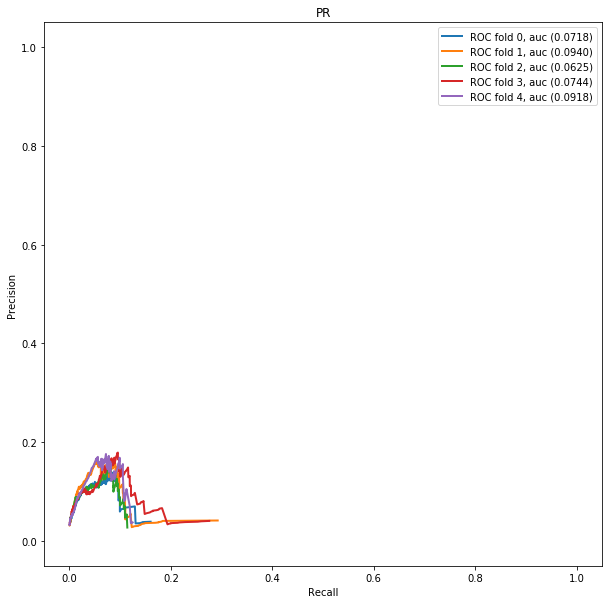

In [259]:
t = pr(snippet_x, snippet_y, len(annotations) - snippet_count)

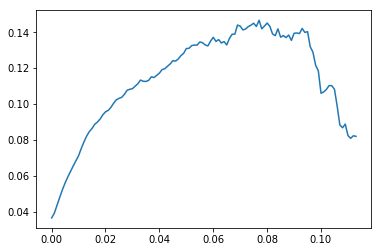

In [248]:
plt.plot(np.linspace(0, 1, 1000), t)

In [215]:
 t[np.isinf(t)] = 0.0

In [229]:
np.argmax(t[:114])

77

In [230]:
np.linspace(0, 1, 1000)[77]

0.077077077077077075

In [217]:
np.max(zip(t, np.linspace(0, 1, 1000)))

nan

In [184]:
np.linspace(0, 1, 100)

array([ 0.        ,  0.01010101,  0.02020202,  0.03030303,  0.04040404,
        0.05050505,  0.06060606,  0.07070707,  0.08080808,  0.09090909,
        0.1010101 ,  0.11111111,  0.12121212,  0.13131313,  0.14141414,
        0.15151515,  0.16161616,  0.17171717,  0.18181818,  0.19191919,
        0.2020202 ,  0.21212121,  0.22222222,  0.23232323,  0.24242424,
        0.25252525,  0.26262626,  0.27272727,  0.28282828,  0.29292929,
        0.3030303 ,  0.31313131,  0.32323232,  0.33333333,  0.34343434,
        0.35353535,  0.36363636,  0.37373737,  0.38383838,  0.39393939,
        0.4040404 ,  0.41414141,  0.42424242,  0.43434343,  0.44444444,
        0.45454545,  0.46464646,  0.47474747,  0.48484848,  0.49494949,
        0.50505051,  0.51515152,  0.52525253,  0.53535354,  0.54545455,
        0.55555556,  0.56565657,  0.57575758,  0.58585859,  0.5959596 ,
        0.60606061,  0.61616162,  0.62626263,  0.63636364,  0.64646465,
        0.65656566,  0.66666667,  0.67676768,  0.68686869,  0.69

In [260]:
sum(full_y)

153